<a href="https://colab.research.google.com/github/vsarunhah/Image-Classifier/blob/master/Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.2.0
Is using GPU? []


In [3]:
def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

170500096/170498071 [==============================] - 4s 0us/step
(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


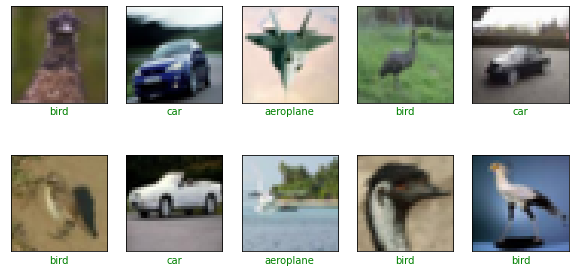

In [5]:
class_names = ['aeroplane', 'car', 'bird']

def show_rand_ex(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show
    
show_rand_ex(x_train, y_train, y_train)

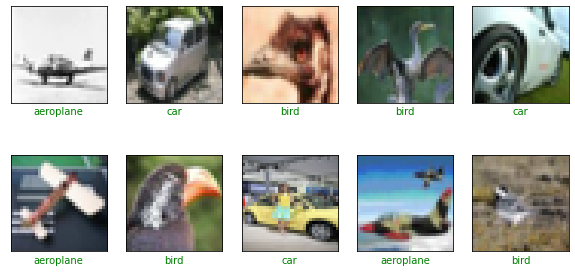

In [6]:
show_rand_ex(x_test, y_test, y_test)

In [7]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32, 32, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

In [8]:
hist = model.fit(
    x_train/255,
    y_train,
    validation_data=(x_test/255, y_test),
    epochs = 10, batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
        tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5', 
                                           save_best_only=True,
                                           save_weights_only=False,
                                           monitor='val_accuracy')
    ])

Epoch 1/10
118/118 [==============================] - 84s 711ms/step - loss: 0.9043 - accuracy: 0.6737 - val_loss: 2.4123 - val_accuracy: 0.3333
Epoch 2/10
118/118 [==============================] - 84s 712ms/step - loss: 0.5486 - accuracy: 0.7778 - val_loss: 2.5186 - val_accuracy: 0.3390
Epoch 3/10
118/118 [==============================] - 84s 710ms/step - loss: 0.4780 - accuracy: 0.8103 - val_loss: 2.4673 - val_accuracy: 0.3720
Epoch 4/10
118/118 [==============================] - 84s 709ms/step - loss: 0.4358 - accuracy: 0.8297 - val_loss: 1.2477 - val_accuracy: 0.5220
Epoch 5/10
118/118 [==============================] - 84s 710ms/step - loss: 0.3978 - accuracy: 0.8432 - val_loss: 0.7946 - val_accuracy: 0.6883
Epoch 6/10
118/118 [==============================] - 84s 710ms/step - loss: 0.3687 - accuracy: 0.8551 - val_loss: 0.9938 - val_accuracy: 0.6960
Epoch 7/10
118/118 [==============================] - 83s 706ms/step - loss: 0.3393 - accuracy: 0.8699 - val_loss: 0.4354 - val_ac

In [9]:
model.save('models/best_model.h5')

In [ ]:
accs = hist.history['accuracy']
val_accs = hist.history['val_accuracy']

plt.plot(range(10), accs, label='Training Accuracy')
plt.plot(range(10), val_accs, label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model('models/best_model.h5')

In [10]:
preds = model.predict(x_test/255)

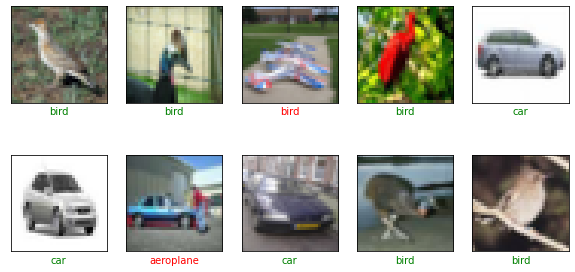

In [13]:
show_rand_ex(x_test, y_test, preds)